# Bridging the Gap Between Purpose and Profit: Analysing the Practice of Impact Investing in Family Offices

### What do trends in named entities and impact-related language in family office reports reveal about philanthrocapitalist investment priorities and their future direction?

In [293]:
import nltk
import string
import PyPDF2
import os
import spacy
import string
import numpy as np

nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
from collections import Counter, defaultdict


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from wordcloud import WordCloud
import pandas as pd

import networkx as nx
from itertools import combinations
from networkx.algorithms import community

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

### Uploading Reports

In [208]:
#Loop that goes through each of the reports in my 'reports' folder, turns them into strings, and removes the line breaks.

pdf_folder = 'reports'
pdf_texts = {}

for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        report_name = filename.replace('.pdf', '').lower()
        with open(os.path.join(pdf_folder, filename), 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                content = page.extract_text()
                if content:
                    text += content + "\n"
            pdf_texts[report_name] = text

In [209]:
ubs24 = pdf_texts['ubs_24']
ubs23 = pdf_texts['ubs_23']
ubs22 = pdf_texts['ubs_22']
pwc24 = pdf_texts['pwc_24']
pwc23 = pdf_texts['pwc_23']
pwc22 = pdf_texts['pwc_22']
citi24 = pdf_texts['citi_24']
citi23 = pdf_texts['citi_23']
citi22 = pdf_texts['citi_22']
campden24 = pdf_texts['campden_24']
campden23 = pdf_texts['campden_23']
campden22 = pdf_texts['campden_22']

In [210]:
type(ubs24)

str

### Cleaning the text

Data cleaning done in 2 stages. 
1. basic cleaning removing punctuation, stop words and non-alphabetic values.
2. tokenisation and lemmatisation of the cleaned data

This was done in two stages as for TF-IDF, I did not want the text to be tokenised or lemmatised, but for other analysis I did. 
I created a loop function for each of these that would go through each report.

In [211]:
def clean_text_spacy(text):
    doc = nlp(text)

    cleaned_tokens = [
        token.text.lower() for token in doc if not token.is_punct and not token.is_stop and token.is_alpha
    ]

    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [212]:
ubs24_basic = clean_text_spacy(ubs24)
ubs23_basic = clean_text_spacy(ubs23)
ubs22_basic = clean_text_spacy(ubs22)
pwc24_basic = clean_text_spacy(pwc24)
pwc23_basic = clean_text_spacy(pwc23)
pwc22_basic = clean_text_spacy(pwc22)
citi24_basic = clean_text_spacy(citi24)
citi23_basic = clean_text_spacy(citi23)
citi22_basic = clean_text_spacy(citi22)
campden24_basic = clean_text_spacy(campden24)
campden23_basic = clean_text_spacy(campden23)
campden22_basic = clean_text_spacy(campden22)

### Tokenising
Creating a loop to tokenise by word.

In [213]:
def get_word_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

### Lemmatising

In [214]:
def lemmatize_words(word_tokens):
    lemmatized_words = []
    for word in word_tokens:
        doc = nlp(word)

        lemmatized_word = doc[0].lemma_
        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

In [215]:
ubs24_clean = lemmatize_words(get_word_tokens(ubs24_basic))
ubs23_clean = lemmatize_words(get_word_tokens(ubs23_basic))
ubs22_clean = lemmatize_words(get_word_tokens(ubs22_basic))
pwc24_clean = lemmatize_words(get_word_tokens(pwc24_basic))
pwc23_clean = lemmatize_words(get_word_tokens(pwc23_basic))
pwc22_clean = lemmatize_words(get_word_tokens(pwc22_basic))
citi24_clean = lemmatize_words(get_word_tokens(citi24_basic))
citi23_clean = lemmatize_words(get_word_tokens(citi23_basic))
citi22_clean = lemmatize_words(get_word_tokens(citi22_basic))
campden24_clean = lemmatize_words(get_word_tokens(campden24_basic))
campden23_clean = lemmatize_words(get_word_tokens(campden23_basic))
campden22_clean = lemmatize_words(get_word_tokens(campden22_basic))

### Exploratory Data Analysis: EDA

Analysing word frequencies, keyword frequencies, and comparison of word frequency across the years of each report

In [271]:
reports = {
    'ubs24': ubs24_clean,
    'ubs23': ubs23_clean,
    'ubs22': ubs22_clean,
    'pwc24': pwc24_clean,
    'pwc23': pwc23_clean,
    'pwc22': pwc22_clean,
    'citi24': citi24_clean,
    'citi23': citi23_clean,
    'citi22': citi22_clean,
    'campden24': campden24_clean,
    'campden23': campden23_clean,
    'campden22': campden22_clean,
}

In [272]:
report_frequencies = {name: Counter(tokens) for name, tokens in reports.items()}

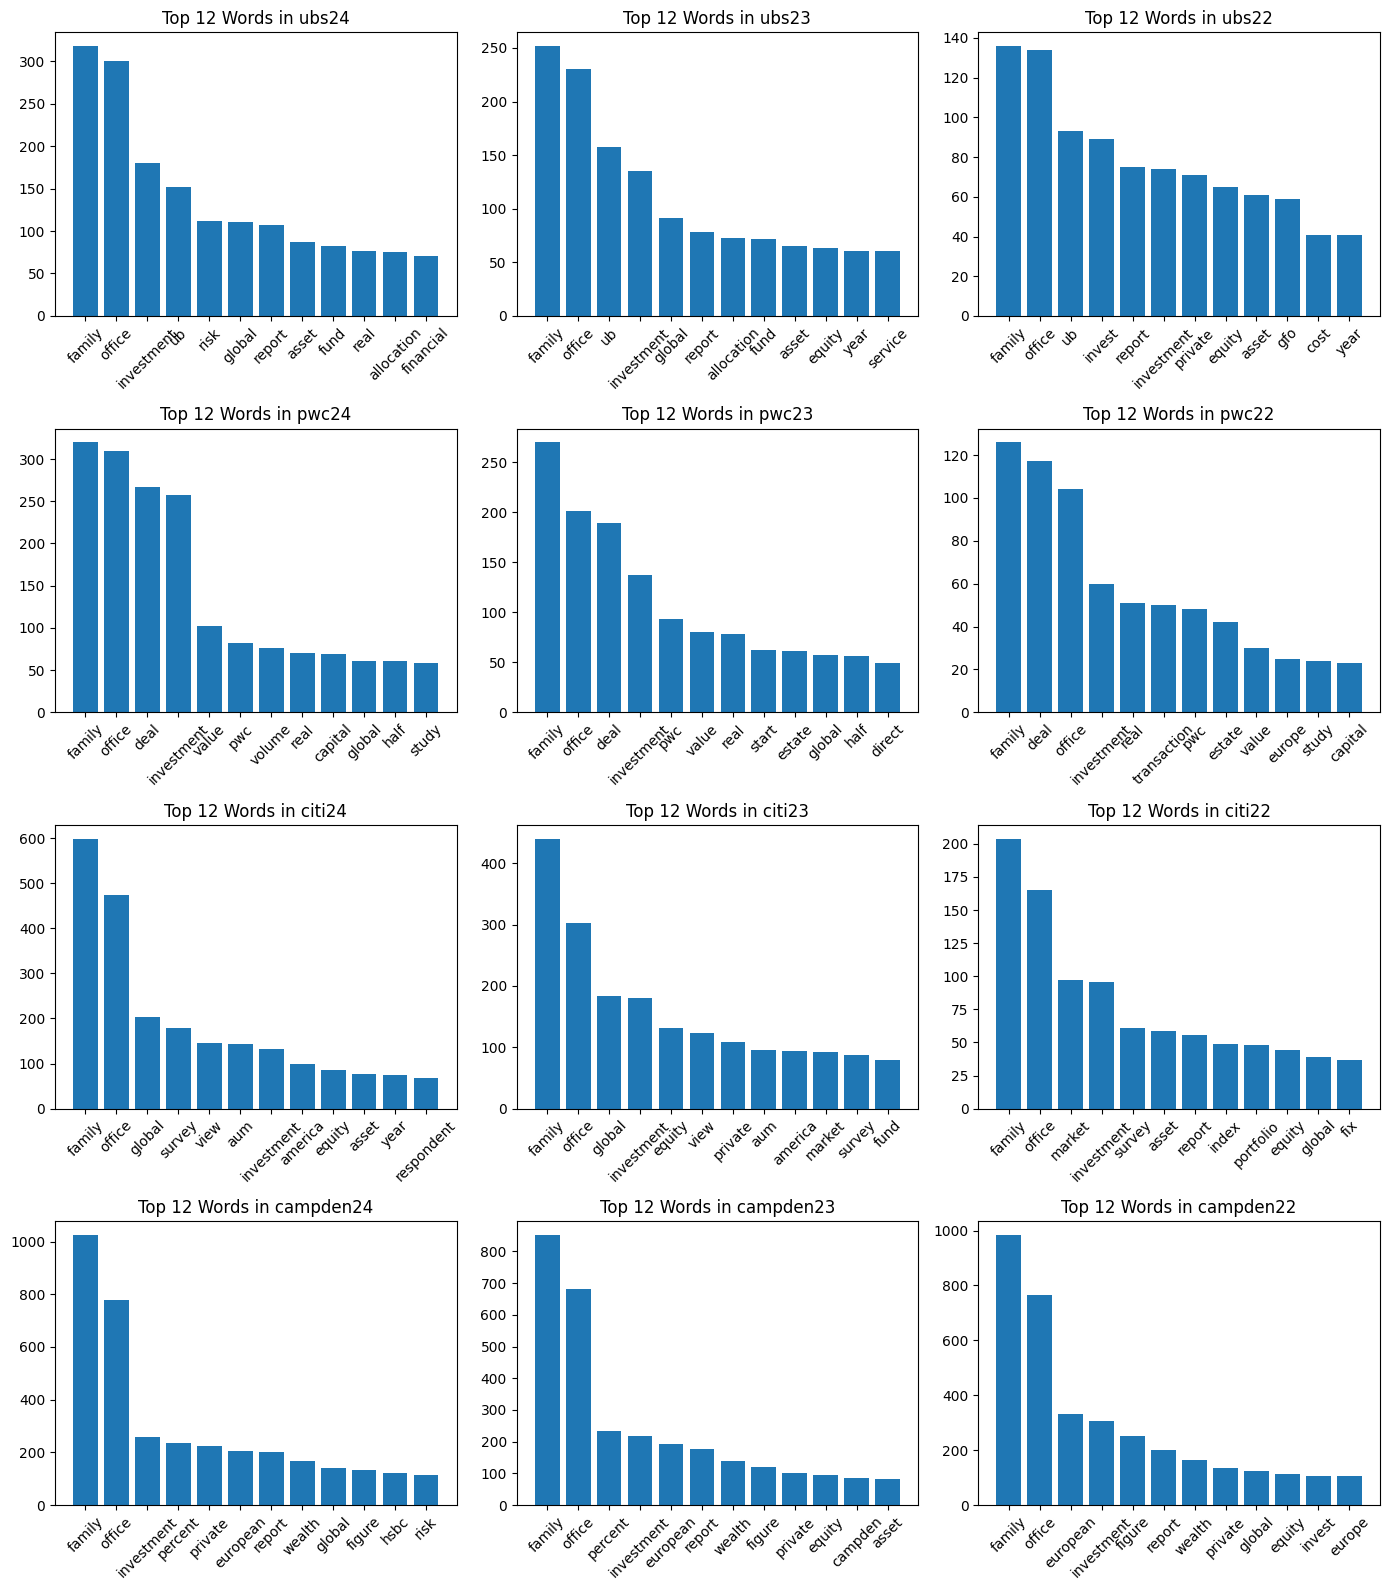

In [273]:
num_reports = len(report_frequencies)
cols = 3
rows = (num_reports + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

plot_idx = 0

for name, freq in report_frequencies.items():
    common = freq.most_common(12)
#    if not common:
#        print(f"⚠️ Skipping {name} - no word frequencies.")
#        continue

    words, counts = zip(*common)
    
    ax = axes[plot_idx]
    ax.bar(words, counts)
    ax.set_title(f"Top 12 Words in {name}")
    ax.tick_params(axis='x', rotation=45)
    
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [274]:
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 'philanthropy', 'philanthropic', 'climate', 'governance']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  sustainable: 2
  impact: 21
  sustainability: 21
  environmental: 1
  philanthropy: 5
  philanthropic: 1
  climate: 19
  governance: 7

ubs23
  sustainable: 4
  impact: 4
  sustainability: 1
  environmental: 1
  philanthropy: 2
  philanthropic: 0
  climate: 0
  governance: 9

ubs22
  sustainable: 17
  impact: 16
  sustainability: 5
  environmental: 2
  philanthropy: 2
  philanthropic: 0
  climate: 3
  governance: 1

pwc24
  sustainable: 13
  impact: 48
  sustainability: 6
  environmental: 3
  philanthropy: 0
  philanthropic: 0
  climate: 7
  governance: 0

pwc23
  sustainable: 3
  impact: 3
  sustainability: 1
  environmental: 1
  philanthropy: 0
  philanthropic: 0
  climate: 2
  governance: 2

pwc22
  sustainable: 0
  impact: 0
  sustainability: 0
  environmental: 0
  philanthropy: 0
  philanthropic: 0
  climate: 0
  governance: 0

citi24
  sustainable: 19
  impact: 7
  sustainability: 4
  environmental: 8
  philanthropy: 7
  philanthropic: 17
  climate: 2
  governance: 27

c

In [275]:
reports_2022 = ['ubs22', 'pwc22', 'citi22', 'campden22']
reports_2023 = ['ubs23', 'pwc23', 'citi23', 'campden23']
reports_2024 = ['ubs24', 'pwc24', 'citi24', 'campden24']

keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 
            'philanthropy', 'philanthropic', 'climate', 'governance',
            'esg', 'sdg']

def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, keywords)
counts_2023 = count_keywords(reports_2023, keywords)
counts_2024 = count_keywords(reports_2024, keywords)

In [276]:
counts_2022

{'sustainable': 70,
 'impact': 61,
 'sustainability': 21,
 'environmental': 14,
 'philanthropy': 17,
 'philanthropic': 20,
 'climate': 8,
 'governance': 42,
 'esg': 32,
 'sdg': 0}

In [277]:
counts_2023

{'sustainable': 73,
 'impact': 29,
 'sustainability': 13,
 'environmental': 8,
 'philanthropy': 43,
 'philanthropic': 35,
 'climate': 12,
 'governance': 48,
 'esg': 12,
 'sdg': 0}

In [278]:
counts_2024

{'sustainable': 39,
 'impact': 94,
 'sustainability': 35,
 'environmental': 20,
 'philanthropy': 36,
 'philanthropic': 30,
 'climate': 34,
 'governance': 77,
 'esg': 36,
 'sdg': 0}

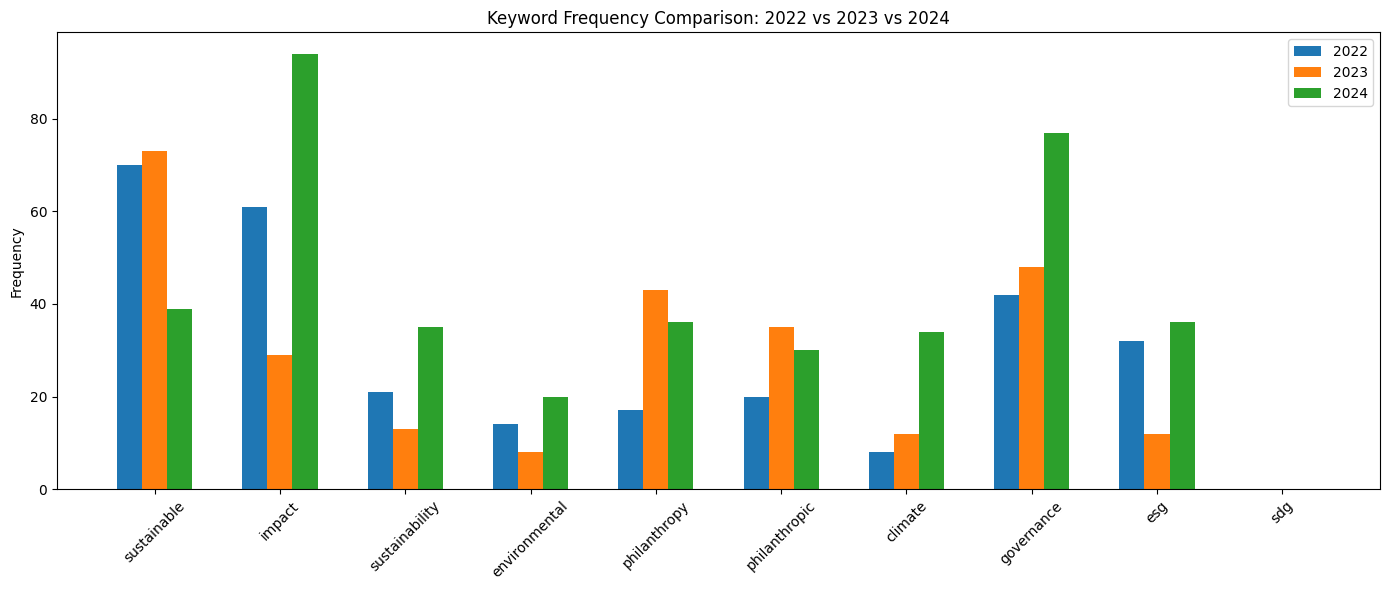

In [279]:
labels = keywords
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Keyword Frequency Comparison: 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### Keywords from academic literature 

- Intentionality
- Additionality
- Attribution
- Contribution
- Materiality 
- Measurement / Measurability
- Risk
- Generation/ Generational

In [287]:
academic_keywords = ['intention', 'addition', 'contribute', 'material', 'advisor', 'measure', 'generation', 'generational', 'risk']
academic_keywords_risk = ['intention', 'addition', 'contribute', 'material', 'advisor', 'measure', 'measurement', 'risk', 'generation', 'generational']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in academic_keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  intention: 0
  addition: 0
  contribute: 1
  material: 19
  advisor: 9
  measure: 5
  generation: 7
  generational: 9
  risk: 112

ubs23
  intention: 0
  addition: 1
  contribute: 1
  material: 7
  advisor: 9
  measure: 1
  generation: 4
  generational: 6
  risk: 28

ubs22
  intention: 1
  addition: 1
  contribute: 1
  material: 1
  advisor: 5
  measure: 6
  generation: 1
  generational: 1
  risk: 13

pwc24
  intention: 1
  addition: 1
  contribute: 0
  material: 0
  advisor: 0
  measure: 1
  generation: 8
  generational: 2
  risk: 7

pwc23
  intention: 0
  addition: 3
  contribute: 1
  material: 0
  advisor: 2
  measure: 1
  generation: 4
  generational: 1
  risk: 17

pwc22
  intention: 0
  addition: 1
  contribute: 1
  material: 1
  advisor: 1
  measure: 0
  generation: 1
  generational: 0
  risk: 3

citi24
  intention: 1
  addition: 0
  contribute: 2
  material: 2
  advisor: 3
  measure: 8
  generation: 47
  generational: 13
  risk: 37

citi23
  intention: 3
  addition: 0
 

In [288]:
def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, academic_keywords)
counts_2023 = count_keywords(reports_2023, academic_keywords)
counts_2024 = count_keywords(reports_2024, academic_keywords)

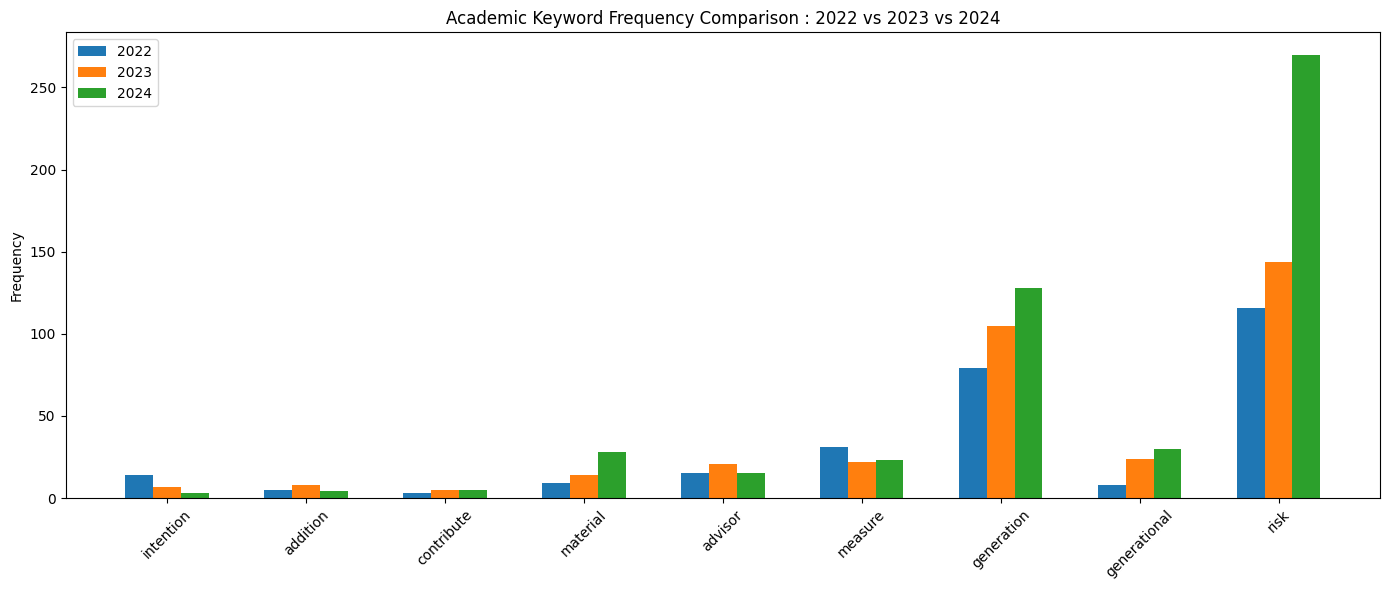

In [291]:
labels = academic_keywords
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Academic Keyword Frequency Comparison : 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### N-Gram Analysis

N-Gram analysis looks at the breakdown of words 2-gram (bigram) or 3-gram (trigram) in this case, and the freqyency of them. This is key to analyze patterns and relationships within data.

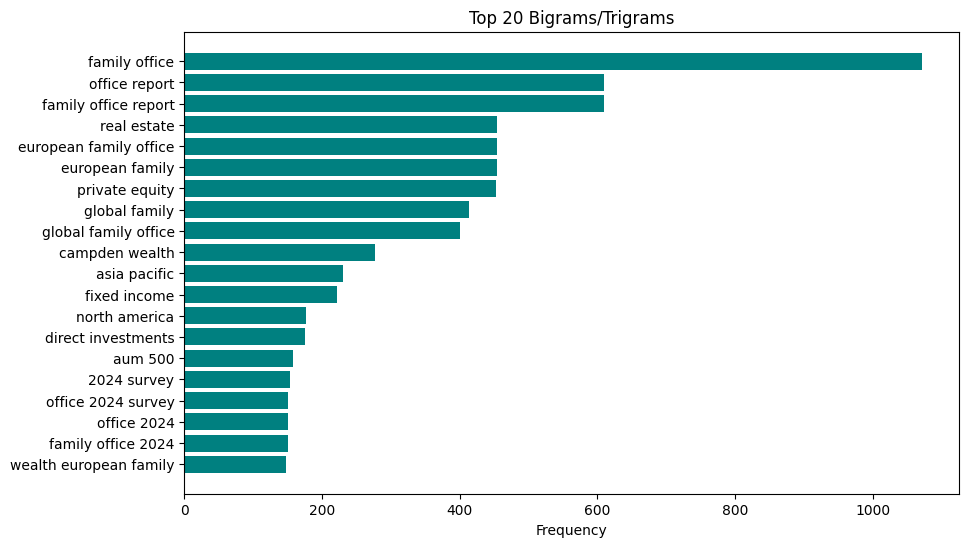

                         ngram  count
65134            family office   1072
101887           office report    610
65157     family office report    610
117500             real estate    455
61258   european family office    455
61257          european family    455
113322          private equity    453
72270            global family    413
72274     global family office    401
38227           campden wealth    277
30847             asia pacific    230
67584             fixed income    222
100589           north america    177
53161       direct investments    175
32497                  aum 500    158
8550               2024 survey    154
101799      office 2024 survey    150
101798             office 2024    150
65135       family office 2024    150
147751  wealth european family    148


In [262]:
documents = [ubs24, ubs23, ubs22, pwc24, pwc23, pwc22, citi24, citi23, citi22, campden24, campden23, campden22]

vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(ngram_documents)

bigrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

bigram_freq = pd.DataFrame({'ngram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

top_bigrams = bigram_freq.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_bigrams['ngram'], top_bigrams['count'], color='teal')
plt.xlabel('Frequency')
plt.title('Top 20 Bigrams/Trigrams')
plt.gca().invert_yaxis() 
plt.show()
print(bigram_freq.head(20))

N-Gram analysis on keywords - looking more specifically for n-grams that contain impact, sustainable, philanthropy etc. 

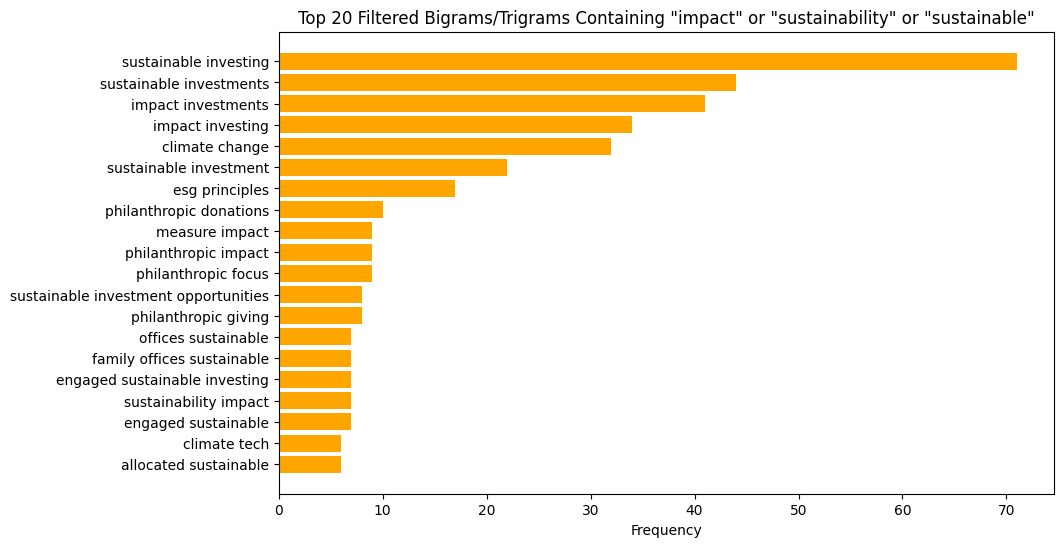

                                       ngram  count
139458                 sustainable investing     71
139523               sustainable investments     44
77721                     impact investments     41
77683                       impact investing     34
41514                         climate change     32
139513                sustainable investment     22
58596                         esg principles     17
110970               philanthropic donations     10
95410                         measure impact      9
111022                  philanthropic impact      9
110996                   philanthropic focus      9
139518  sustainable investment opportunities      8
111012                  philanthropic giving      8
104837                   offices sustainable      7
65072             family offices sustainable      7
56718          engaged sustainable investing      7
139358                 sustainability impact      7
56717                    engaged sustainable      7
41562       

In [263]:
keywords = ['impact', 'sustainable', 'sustainability', 'philanthropy', 'philanthropic', 'climate', 'esg', 'sdg']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='orange')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing "impact" or "sustainability" or "sustainable"')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()
print(top_20_filtered_ngrams)

N-Gram analysis on academic keywords that were pulled out of my literature review

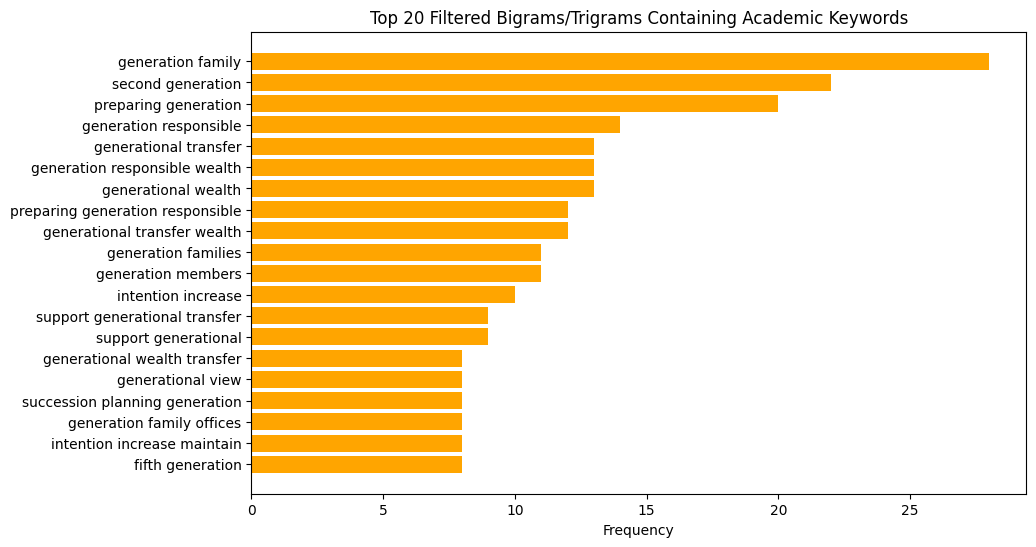

                                   ngram  count
70984                  generation family     28
129625                 second generation     22
114648              preparing generation     20
71120             generation responsible     14
71207              generational transfer     13
71122      generation responsible wealth     13
71226                generational wealth     13
114655  preparing generation responsible     12
71209       generational transfer wealth     12
70973                generation families     11
71059                 generation members     11
82186                 intention increase     10
138388     support generational transfer      9
138387              support generational      9
71230       generational wealth transfer      8
71219                  generational view      8
137965    succession planning generation      8
70993          generation family offices      8
82189        intention increase maintain      8
66186                   fifth generation

In [267]:
academic_keywords = ['intention', 'addition', 'contribute', 'material', 'washing', 'generation', 'risk measuure']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(academic_keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='orange')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing Academic Keywords')
plt.gca().invert_yaxis()
plt.show()
print(top_20_filtered_ngrams)

### Topic Frequency - Inverse Document Frequency: TF-IDF

See what words are distinctive or uniquely important in each report (or bank/year).

1. Each report as its own document 
2. Each bank as its own document 
3. Each year as its own document

### 1. Document Level

In [177]:
def ensure_string(doc):
    return ' '.join(doc) if isinstance(doc, list) else doc

documents = [ensure_string(doc) for doc in [
    ubs22_basic, ubs23_basic, ubs24_basic,
    citi22_basic, citi23_basic, citi24_basic,
    pwc22_basic, pwc23_basic, pwc24_basic,
    campden22_basic, campden23_basic, campden24_basic
]]

In [178]:
doc_labels = ['ubs_22', 'ubs_23', 'ubs24',
              'citi_22', 'citi_23', 'citi_24',
              'pwc_22', 'pwc_23', 'pwc_24',
              'campden_22', 'campden_23', 'campden_24']

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(documents)
tfidf_df = pd.DataFrame(X.toarray(), index=doc_labels, columns=vectorizer.get_feature_names_out())

for doc in tfidf_df.index:
    print(f"\nTop terms in {doc}:")
    print(tfidf_df.loc[doc].sort_values(ascending=False).head(10))


Top terms in ubs_22:
ubs            0.608322
gfo            0.566757
costs          0.113209
western        0.111199
allocation     0.097119
staff          0.096075
income         0.093690
distributed    0.083037
ledger         0.082498
latin          0.082350
Name: ubs_22, dtype: float64

Top terms in ubs_23:
ubs            0.738285
allocations    0.138755
ag             0.134886
se             0.116817
bank           0.111607
offi           0.102933
ces            0.096070
authority      0.094777
german         0.088978
geopolitics    0.088500
Name: ubs_23, dtype: float64

Top terms in ubs24:
ubs            0.699203
income         0.189426
allocations    0.130658
operating      0.121750
rates          0.112557
ag             0.104832
se             0.101200
bank           0.097994
allocation     0.092055
plan           0.086116
Name: ubs24, dtype: float64

Top terms in citi_22:
survey        0.299535
citibank      0.275708
index         0.246738
aum           0.169736
citigroup     

### 2. Bank Level

In [179]:
bank_docs = {
    "UBS": ' '.join(documents[0:3]),
    "Citi": ' '.join(documents[3:6]),
    "PwC": ' '.join(documents[6:9]),
    "Campden": ' '.join(documents[9:12]),
}

In [180]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(bank_docs.values())
tfidf_df_bank = pd.DataFrame(X.toarray(), index=bank_docs.keys(), columns=vectorizer.get_feature_names_out())

# Top terms per bank
for bank in tfidf_df_bank.index:
    print(f"\nTop terms for {bank}:")
    print(tfidf_df_bank.loc[bank].sort_values(ascending=False).head(10))


Top terms for UBS:
ubs            0.787555
allocations    0.155048
gfo            0.146243
allocation     0.128152
ag             0.115495
bank           0.113913
document       0.102838
plan           0.101256
operating      0.098091
unsplash       0.094190
Name: UBS, dtype: float64

Top terms for Citi:
survey         0.463460
view           0.368759
mm             0.272006
citibank       0.238287
vs             0.206815
respondents    0.189402
latin          0.163574
index          0.149226
citi           0.146119
citigroup      0.137127
Name: Citi, dtype: float64

Top terms for PwC:
pwc             0.669527
ofﬁces          0.354279
volume          0.254877
ofﬁce           0.249196
study           0.243379
club            0.175165
june            0.172473
transactions    0.122648
pitchbook       0.114090
ﬁrst            0.108085
Name: PwC, dtype: float64

Top terms for Campden:
percent       0.482354
campden       0.450367
figure        0.369318
fig           0.201520
hsbc          

### 3. Year Level

In [181]:
year_docs = {
    "2022": ' '.join([documents[0], documents[3], documents[6], documents[9]]),
    "2023": ' '.join([documents[1], documents[4], documents[7], documents[10]]),
    "2024": ' '.join([documents[2], documents[5], documents[8], documents[11]]),
}

In [182]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(year_docs.values())
tfidf_df_year = pd.DataFrame(X.toarray(), index=year_docs.keys(), columns=vectorizer.get_feature_names_out())

# Top terms per year
for year in tfidf_df_year.index:
    print(f"\nTop terms for {year}:")
    print(tfidf_df_year.loc[year].sort_values(ascending=False).head(10))


Top terms for 2022:
gfo            0.580323
apply          0.321662
inhouse        0.196720
refinitiv      0.118032
overweight     0.112208
yesno          0.108196
underweight    0.097247
em             0.088524
learn          0.082286
fo             0.078688
Name: 2022, dtype: float64

Top terms for 2023:
ofﬁces      0.624058
ofﬁce       0.438956
fig         0.225240
ﬁrst        0.190391
amily       0.100484
ups         0.088487
controls    0.080443
offi        0.079329
ces         0.074041
bullish     0.072399
Name: 2023, dtype: float64

Top terms for 2024:
hsbc          0.589395
fig           0.373284
pitchbook     0.176819
infralogic    0.142080
disagree      0.122791
chart         0.122706
display       0.116248
volumedeal    0.109789
generative    0.109789
likelier      0.093321
Name: 2024, dtype: float64


Tracking for specific keywords
- tried doing this but didnt work very well as the frequencies arent that high compared to other words

### Semantic similarity modelling

In [183]:
from sentence_transformers import SentenceTransformer, util

# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your yearly documents
year_texts = list(year_docs.values())
years = list(year_docs.keys())

# Encode year documents
year_embeddings = model.encode(year_texts, convert_to_tensor=True)

# Define your concept phrase(s)
concepts = ["sustainability", "impact", "climate change", "social impact", "esg", "impact investing", "governance", "sustainable investing", "sdg", "philanthropy"]
concept_embeddings = model.encode(concepts, convert_to_tensor=True)

# Calculate similarity
similarities = util.cos_sim(concept_embeddings, year_embeddings)

# Display results
import pandas as pd
sim_df = pd.DataFrame(similarities.cpu().numpy(), index=concepts, columns=years)
print(sim_df.round(3))


                        2022   2023   2024
sustainability         0.218  0.134  0.171
climate change         0.067  0.042  0.125
social impact          0.211  0.137  0.202
esg                   -0.005 -0.001 -0.045
impact investing       0.365  0.288  0.290
governance             0.184  0.131  0.148
sustainable investing  0.404  0.317  0.293
sdg                   -0.004 -0.039 -0.031
philanthropy           0.222  0.164  0.121


In [184]:
print(sim_df.columns)


Index(['2022', '2023', '2024'], dtype='object')


### Cosine clustering

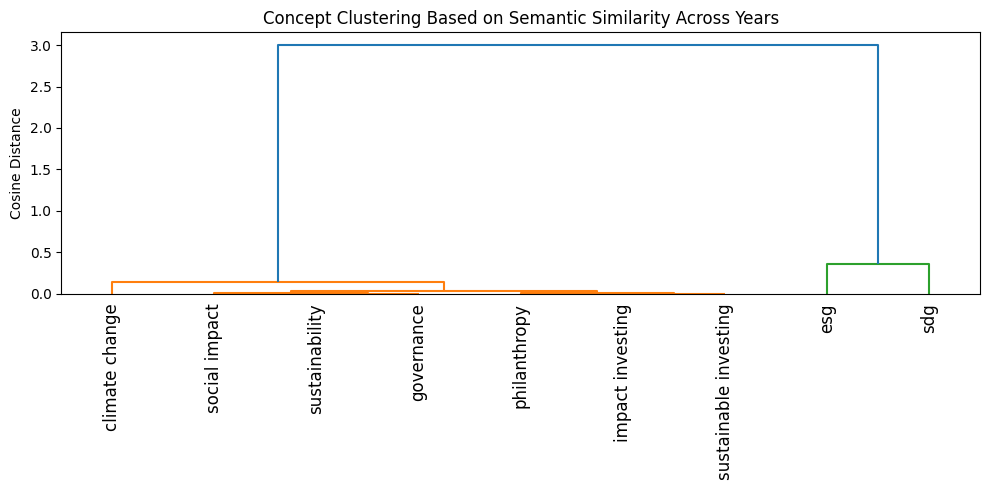

In [185]:
#df_sim = sim_df.set_index("concepts")  # if needed

# 2. Compute cosine distance matrix (1 - cosine similarity)
distance_matrix = pdist(sim_df.values, metric='cosine')

# 3. Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # 'ward' or 'average'

# 4. Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=sim_df.index, leaf_rotation=90)
plt.title("Concept Clustering Based on Semantic Similarity Across Years")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()

### Named Entity Recognition

used to identify and classify key information (entities) in text into predefined categories such as:

"ORG" - for organisations, locations, people

"PERSON" – for people

"GPE" – for countries, cities, states

"DATE" – for time-related entities

"MONEY" – for monetary values



In [295]:
ENTITY_TYPE = "GPE"  

entity_counts_by_year = defaultdict(Counter)

# Loop through years and texts
for year, text in year_docs.items():
    doc = nlp(text)  # Run NLP processing
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(10)
    for entity, count in top_entities:
        entity_counts_by_year[year][entity] = count

df = pd.DataFrame(entity_counts_by_year).fillna(0).astype(int)
df = df.T

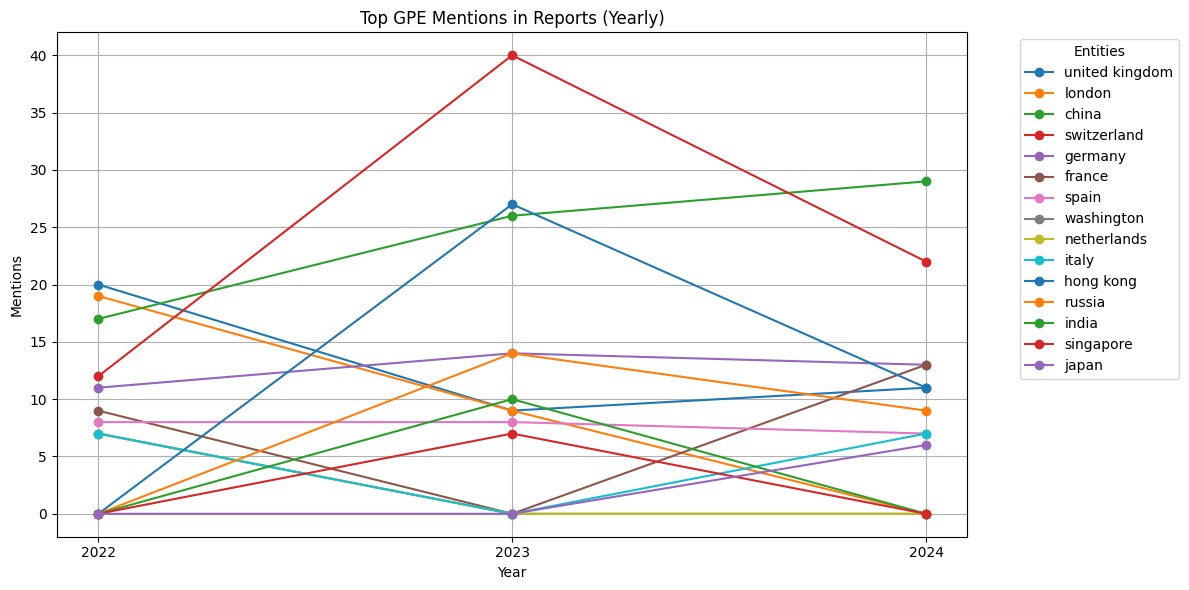

In [294]:
plt.figure(figsize=(12, 6))

for entity in df.columns:
    plt.plot(df.index, df[entity], label=entity, marker='o')

plt.title(f"Top {ENTITY_TYPE} Mentions in Reports (Yearly)")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.legend(title="Entities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [299]:
ENTITY_TYPE = "GPE"  
top_n = 5  

entity_counts_by_bank = {}

for bank, text in bank_docs.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(top_n)
    entity_counts_by_bank[bank] = top_entities


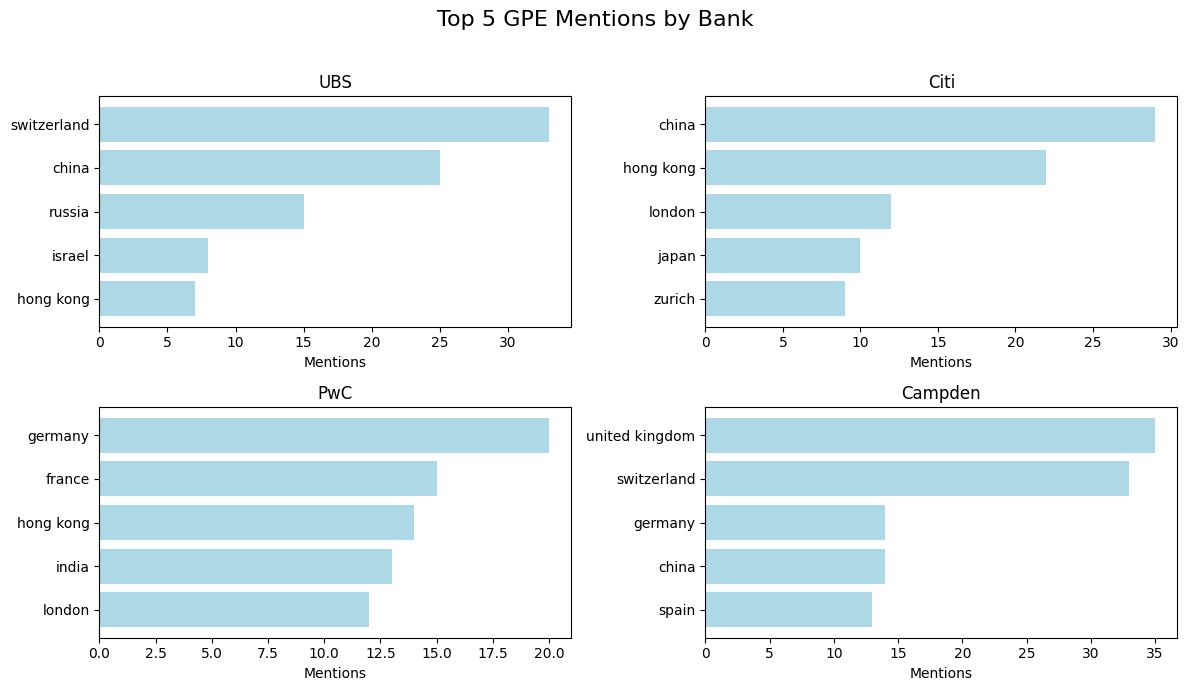

In [301]:
num_banks = len(entity_counts_by_bank)
cols = 2
rows = (num_banks + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3.5))
axes = axes.flatten()

for idx, (bank, entities) in enumerate(entity_counts_by_bank.items()):
    labels, counts = zip(*entities)
    axes[idx].barh(labels, counts, color='lightblue')
    axes[idx].invert_yaxis()  # Highest count on top
    axes[idx].set_title(bank)
    axes[idx].set_xlabel("Mentions")

# Turn off empty subplots (if any)
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle(f"Top {top_n} {ENTITY_TYPE} Mentions by Bank", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [190]:
all_text = ' '.join(documents)

ENTITY_TYPE = "GPE"  # Change as needed

entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]

top_entities = Counter(entities).most_common(10)
print(f"\nTop {ENTITY_TYPE} entities in all documents:")
for entity, count in top_entities:
    print(f"  {entity}: {count}")


Top GPE entities in all documents:
  united kingdom: 35
  switzerland: 33
  germany: 14
  china: 14
  spain: 13
  london: 8
  luxembourg: 6
  france: 6
  italy: 5
  kingdom: 5


### Network analysis of named entity

In [191]:
entity_docs = [
    list(set([ent.text for ent in nlp(doc).ents if ent.label_ == "GPE"])) 
    for doc in documents
]

# Flatten list of entities and get the top 20 most common
top_entities = [ent for ent, _ in Counter([ent for doc in entity_docs for ent in doc]).most_common(20)]

# Filter entity_docs to include only top entities
filtered_entity_docs = [
    [ent for ent in doc if ent in top_entities] 
    for doc in entity_docs
]

In [192]:
G = nx.Graph()

# Add nodes and edges based on filtered entities
for doc in filtered_entity_docs:
    for entity in doc:
        if not G.has_node(entity):
            G.add_node(entity)
        for other_entity in doc:
            if entity != other_entity:
                G.add_edge(entity, other_entity)
                

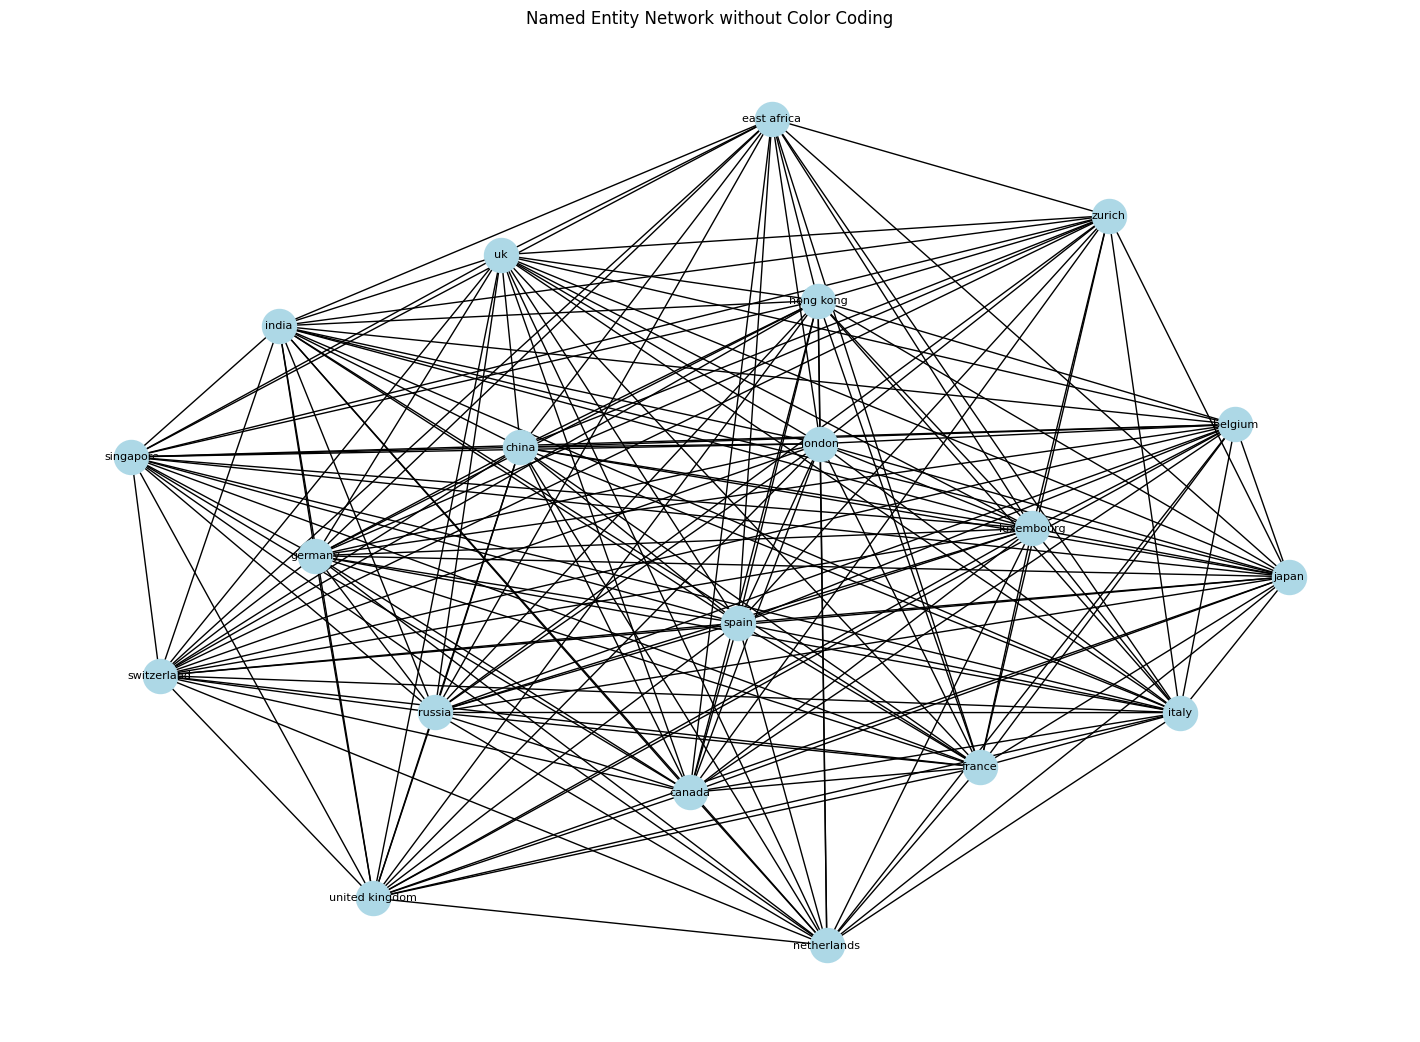

In [193]:
# Draw the graph with uniform color for all nodes
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.3)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=8)
plt.title("Named Entity Network without Color Coding")
plt.show()